# *************************************************************
#Pontifícia Universidade Católica de Minas Gerais - PUC-Minas
# Pós Graduação em Ciência de Dados e Big Data
# Trabalho de Conclusão de Curso
## Um Modelo de Aprendizado de Máquina Supervisionado para Previsão de Quantidade de Público nos Jogos do Campeonato Brasileiro de Futebol

## Autor: Salomão Fernandes de Freitas Júnior
## ABRIL/2024


## ETAPA 3: Escolha do Modelo de Machine Learning

## Importação de Bibliotecas e Leitura de datasets





In [3]:
# Importação de Bibliotecas
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np



In [4]:
# Leitura do dataset preparado final, gerado no notebook 02-Preparação de Dados
df_brasileirao = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PUC Minas - TCC Ciência de Dados/Datasets/brasileirao_serie_a_preparada_final_op2.csv', sep= ';', encoding='utf-8')

#Exibição de algumas linhas para observação
display(df_brasileirao.sample(6))

print('')
print('')

# Para nossa referência, vamos ver a estatística descritiva da variável publico, nossa variável alvo a ser predita
print('### Estatística Descritia da variável publico ###')
df_brasileirao['publico'].describe().round(2)

,rodada,points_mand_last_5,points_visit_last_5,colocacao_mandante_antes,colocacao_visitante_antes,grau_investimento_mandante,grau_investimento_visitante,publico,trimestre_3º Trimestre,trimestre_4º Trimestre,...,time_visitante_Paraná,time_visitante_Ponte Preta,time_visitante_Portuguesa,time_visitante_RB Bragantino,time_visitante_Santa Cruz,time_visitante_Santo André,time_visitante_Santos,time_visitante_Sport Recife,time_visitante_São Paulo,time_visitante_Vasco da Gama
216,0.567568,0.600000,0.400000,0.105263,0.894737,0.25,0.00,9619.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2566,0.351351,0.466667,0.466667,0.368421,0.789474,1.00,0.25,29115.0,1,0,...,0,0,0,0,0,0,0,0,0,0
3016,0.567568,0.466667,0.333333,0.052632,0.368421,1.00,0.50,12064.0,1,0,...,0,0,0,0,0,0,0,0,0,0
3744,0.486486,0.200000,0.466667,0.842105,0.631579,0.50,0.50,12871.0,1,0,...,0,0,0,0,0,0,0,0,0,0
181,0.486486,0.466667,0.600000,0.578947,0.157895,0.50,0.00,33686.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4687,1.000000,0.200000,0.533333,0.894737,0.263158,0.25,0.75,9498.0,0,1,...,0,0,0,0,0,0,0,0,1,0




### Estatística Descritia da variável publico ###


count     5601.00
mean     18099.70
std      13237.74
min        286.00
25%       8443.00
50%      14403.00
75%      24564.00
max      82044.00
Name: publico, dtype: float64

## Primeiro teste com um modelo simples de Regressão Linear

In [ ]:
# Vamos aplicar um modelo de regressão linear, pois queremos prever uma variável numérica e contínua (publico)
from sklearn.linear_model import LinearRegression # Modelo
from sklearn.model_selection import train_test_split # Estratégia de Validação
from sklearn.metrics import mean_squared_error  # Métricas de avaliação
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Divide a base em variáveis de entrada e variável a ser predita
X = df_brasileirao.drop('publico', axis = 1) #variáveis de entrada - parâmetros. Todas menos publico
y = df_brasileirao['publico'] # variável a ser predita (target)

# Separando os dados da nossa base em teste e treino (Estratégia de Validação)
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.25) #, random_state=25) # colocando 75% para treino e 25% para teste

# Ajuste do modelo nos dados de treino
regressao = LinearRegression()  # Modelo
regressao.fit(X_treino, y_treino) # treinamento com os dados separados para isso

# Utilizando o modelo ajustado (treinado) para predizer os dados separados para teste
y_pred = regressao.predict(X_teste)

# Métricas de Avaliação
mse = mean_squared_error(y_teste, y_pred)  # Erro quadrático médio (quanto menor, melhor)
rmse = np.sqrt(mse) # Raiz quadrada do mse (quanto menor, melhor)
mae = mean_absolute_error(y_teste, y_pred) # # Erro médio absoluto (quanto menor, melhor)
r2 = r2_score(y_teste, y_pred)  # R quadrado  (entre 0 e 1, quanto mais próximo de 1, melhor)

# Visualiza as métricas calculadas
print("MSE da Regressão Linear: {:.2f}".format(mse))
print("RMSE da Regressão Linear: {:.2f}".format(rmse))
print("MAE da Regressão Linear: {:.2f}".format(mae))
print("R2 da Regressão Linear: {:.2f}".format(r2))
print('')

# Visualiza um parte dos valores reais e dos respctivos valores preditos para comparação
print('Valores Reais   : ', list(y_teste[0:10].round(2)))
print('Valores Preditos: ', list(y_pred[0:10].round(2)))


MSE da Regressão Linear: 101427835.91
RMSE da Regressão Linear: 10071.14
MAE da Regressão Linear: 7373.02
R2 da Regressão Linear: 0.44

Valores Reais   :  [10845.0, 10791.0, 24992.0, 14129.0, 37507.0, 19974.0, 18512.0, 41764.0, 8271.0, 7780.0]
Valores Preditos:  [21162.92, 12043.52, 17266.44, 18547.39, 26030.31, 20839.28, 13752.96, 27413.5, 14675.37, 11490.61]


In [ ]:
## AGORA EXECUTANDO VÁRIAS VEZES PARA OBSERVAR O MELHOR RESULTADO ALCANÇADO
rep = 100
mses = [] # erro quadrático médio
rmses = [] # raiz quadrada do erro quadrático médio
maes = [] # erro abosoluto médio
r2s = [] # R quadrado



for i in range(rep):
  # Separando os dados da nossa base em teste e treino (Estratégia de Validação)
  X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.25) #, random_state=25) # colocando 75% para treino e 25% para teste

  # Ajuste do modelo nos dados de treino
  regressao = LinearRegression()  # Modelo
  regressao.fit(X_treino, y_treino) # treinamento com os dados separados para isso

  # Utilizando o modelo ajustado (treinado) para predizer os dados separados para teste
  y_pred = regressao.predict(X_teste)

  # Métricas de Avaliação
  mses.append(mean_squared_error(y_teste, y_pred))  # Erro quadrático médio (quanto menor, melhor)
  rmses.append(np.sqrt(mean_squared_error(y_teste, y_pred))) # Raiz quadrada do mse (quanto menor, melhor)
  maes.append(mean_absolute_error(y_teste, y_pred)) # # Erro médio absoluto (quanto menor, melhor)
  r2s.append(r2_score(y_teste, y_pred))  # R quadrado  (entre 0 e 1, quanto mais próximo de 1, melhor)

# Visualiza as métricas calculadas (médias)
print('### MÉDIAS DAS MÉTRICAS ##')
#print('MSE da Regressão Linear: {:.2f}'.format(sum(mse) / len(mse))) #format(np.mean(mse)))
mse = np.array(mses).mean().round(2)
rmse = np.array(rmses).mean().round(2)
mae = np.array(maes).mean().round(2)
r2 = np.array(r2s).mean().round(2)

print('MSE da Regressão Linear: ', mse)
print('RMSE da Regressão Linear: ', rmse)
print('MAE da Regressão Linear: ', mae)
print('R2 da Regressão Linear: ', r2)
print('')

# Melhores Valores
print('### MELHORES VALORES DAS MÉTRICAS ##')
print('MSE da Regressão Linear: {:.2f}'.format(min(mses)))
print('RMSE da Regressão Linear: {:.2f}'.format(min(rmses)))
print('MAE da Regressão Linear: {:.2f}'.format(min(maes)))
print('R2 da Regressão Linear: {:.2f}'.format(max(r2s)))
print('')


# Visualiza um parte dos valores reais e dos respctivos valores preditos para comparação
#print('Valores Reais   : ', list(y_teste[0:10].round(2)))
#print('Valores Preditos: ', list(y_pred[0:10].round(2)))


### MÉDIAS DAS MÉTRICAS ##
MSE da Regressão Linear:  1.3132201218022449e+28
RMSE da Regressão Linear:  11459581685354.24
MAE da Regressão Linear:  530286205609.28
R2 da Regressão Linear:  -7.866567509294925e+19

### MELHORES VALORES DAS MÉTRICAS ##
MSE da Regressão Linear: 88851444.90
RMSE da Regressão Linear: 9426.10
MAE da Regressão Linear: 6883.12
R2 da Regressão Linear: 0.49



# APLICANDO MELHORES TÉCNICAS DE VALIDAÇÃO E TESTANDO VÁRIOS MODELOS E PARÂMETROS
#### O teste acima foi apenas uma primeira avaliação. No entanto não é tão simples assim. Precisamos aplicar outras técnicas de validação e testar vários algorítmos de machine learning, variando seus hiper-parâmetros

## TESTANDO VÁRIOS MODELOS COM HIPER-PARÂMETROS FIXOS

In [ ]:
 # Modelos
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

# Estratégias de Validação
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

# Métricas de avaliação
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import r2_score
#from sklearn.metrics import mean_absolute_error



In [ ]:
# Para verificar as métricas que podemos passar no cross validate
#from sklearn.metrics import get_scorer_names
#get_scorer_names()
#https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [ ]:
# Comparando vários modelos
#Lista de Modelos que vamos Usar
modelos = [LinearRegression(fit_intercept = True),
           LinearRegression(fit_intercept = False),
           KNeighborsRegressor(n_neighbors = 5),
           KNeighborsRegressor(n_neighbors = 15),
           KNeighborsRegressor(n_neighbors = 35),
           DecisionTreeRegressor(max_depth = 3, min_samples_split=70),
           DecisionTreeRegressor(max_depth = 5, min_samples_split=70),
           DecisionTreeRegressor(max_depth = 5, min_samples_split=30),
           RandomForestRegressor(),
           ExtraTreesRegressor()]


# Lista com os nomes dos modelos respectivos
nomes = ['Regressão Linear (fit_intercept = True)',
         'Regressão Linear (fit_intercept = False)',
         'KNN - K = 5',
         'KNN - K = 15',
         'KNN - K = 35',
         'Árvore - Prof = 3, min amostras = 70',
         'Árvore - Prof = 5, min amostras = 70',
         'Árvore - Prof = 5, min amostras = 30',
         'Random Forrest',
         'ExtraTrees']


# a Nossa estratégia de validação será o kfold
validacao = KFold(n_splits = 10, shuffle = True)  # vai dividir em 10 partes para variar os dados de treino e teste (1 das partes é conjunto de teste, as demais são de treino)
                                                  # executa 10 rodadas com a mesma divisão, mas variando a parte de teste a cada rodada
                                                  # shuffle = True -> sempre que executar essa linha vai dividir aleatoriamente (diferente da execução anterior)

# Divide a base em variáveis de entrada e variável a ser predita
X = df_brasileirao.drop('publico', axis = 1) #variáveis de entrada - parâmetros. Todas menos publico
y = df_brasileirao['publico'] # variável a ser predita (target)

# Listas para guardar os valores das métricas dos testes
mses = [] # erro quadrático médio
rmses = [] # raiz quadrada do erro quadrático médio
maes = [] # erro abosoluto médio
r2s = [] # R quadrado




#Aplicando cada modelo e guardando os resultados
for modelo in modelos:
    print('### Rodando Modelo: ', modelo, '###')

    # Aplicamos o cross validate, pasando nosso modelo da iteração, a base (X e y), o modo de validação, e as métricas de queremos medir
    resultados = cross_validate(modelo, X, y, cv = validacao, scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error','r2'])

    # O cross validate retorna um dicionário com os resultados das métricas medidas nos testes pelo cross validate
    # Como ele executa 10 vezes (no nosso caso, parâmetro), então o resultado e um array numpy com as 10 medições de cada métrica
    # Nos obtemos a média para guardar para esse modelo da iteração
    mses.append(abs(resultados['test_neg_mean_squared_error'].mean()))
    rmses.append(abs(resultados['test_neg_root_mean_squared_error'].mean()))
    maes.append(abs(resultados['test_neg_mean_absolute_error'].mean()))
    r2s.append(abs(resultados['test_r2'].mean()))


#dicionário auxiliar para gerar um DF
dict_aux = {'MSE': mses, 'RMSE': rmses, 'MAE': maes, 'R2': r2s }

resultados = pd.DataFrame(dict_aux, index = nomes) # obtendo um DF a partir do dic, já colocando os nomes da lista como índice
resultados = resultados.sort_values(by = 'MAE').round(1) # Apresentado o DF de resultados, ordenado pelo MSE de teste, para rankear os modelos
resultados

### Rodando Modelo:  LinearRegression() ###
### Rodando Modelo:  LinearRegression(fit_intercept=False) ###
### Rodando Modelo:  KNeighborsRegressor() ###
### Rodando Modelo:  KNeighborsRegressor(n_neighbors=15) ###
### Rodando Modelo:  KNeighborsRegressor(n_neighbors=35) ###
### Rodando Modelo:  DecisionTreeRegressor(max_depth=3, min_samples_split=70) ###
### Rodando Modelo:  DecisionTreeRegressor(max_depth=5, min_samples_split=70) ###
### Rodando Modelo:  DecisionTreeRegressor(max_depth=5, min_samples_split=30) ###
### Rodando Modelo:  RandomForestRegressor() ###
### Rodando Modelo:  ExtraTreesRegressor() ###


,MSE,RMSE,MAE,R2
Random Forrest,90274851.2,9493.6,6809.7,0.5
ExtraTrees,95185321.0,9749.9,6811.6,0.5
Regressão Linear (fit_intercept = False),96440604.2,9815.2,7206.2,0.4
Regressão Linear (fit_intercept = True),96494080.8,9820.3,7206.3,0.4
KNN - K = 15,113015167.2,10617.6,7989.8,0.4
KNN - K = 5,124115551.8,11131.3,8126.1,0.3
KNN - K = 35,113316744.3,10633.2,8133.1,0.4
"Árvore - Prof = 5, min amostras = 70",128079725.5,11308.2,8529.6,0.3
"Árvore - Prof = 5, min amostras = 30",129155485.6,11356.9,8568.9,0.3
"Árvore - Prof = 3, min amostras = 70",139589145.2,11798.3,9068.8,0.2


## MELHORANDO NOSSO TESTE: TUNAGEM DE HIPER-PARÂMETROS
#### Aqui vamos acrescentar vários outros modelos para os testes
#### E realizar a tunagem de hiperparâmetros, onde conseguiremos testar várias configurações de hiperparâmetros para cada modelo
Tunagem de Hiperparâmetros nada mais é do que encontrar qual a melhor combinação de valores de parâmetros que passamos aos algoritmos no momento de seu treinamento. Alguns modelos tem poucos hiperparâmetros que se deseja tunar, outros têm muitos.

In [5]:
 # Modelos
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, BaggingRegressor, VotingRegressor
from sklearn.svm import SVR, LinearSVR  # Suport Vector Machine Regressor
from sklearn.naive_bayes import GaussianNB

# Estratégias de Validação
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
#from sklearn.model_selection import KFold
#from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold

#Funções para procura de melhores parâmetros (Tunagem)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Úteis
from datetime import datetime
import pytz  # timezone - fuso horário

In [6]:
# Função para tunagem
# Recebe os parâmetros e devolve o melhor modelo (combinação de parâmetros) treinado, os melhores parâmetros , e o MAE respectivo (métrica)
def Tunagem(modelo, features, targets, parametros, tipo = 'random', n_iter = 20):
    # o n_iter só é usado se tipo = 'random'. significa o número de combinações que seram testadas no random.
    # se tipo = 'grid', sabemos que testa todas as combinações possíveis

    # As métricas que vamos querer que sejam calculadas
    metricas = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error','r2']

    # vai dividir em 10 partes para variar os dados de treino e teste (1 das partes é conjunto de teste, as demais são de treino)
    # executa 10 rodadas com a mesma divisão, mas variando a parte de teste a cada rodada
    #validacao = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)
    #validacao = RepeatedKFold(n_splits = 10, n_repeats = 3)
    validacao = RepeatedKFold(n_splits = 10, n_repeats = 1) # APENAS PARA SER MAIS RÁPIDO OS TESTES. MAS O CORRETO É O DE CIMA

    #https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    #como estamos usando multiplas métricas, então temos q usar o parâmetro refit = a metrica que será tomada para calculo do best_scorer e classificação do melhor modelo (combinação de parâmetros)
    if tipo == 'grid':
        #GridSearchCV faz a validação cruzada para os vários modelos originados pela variação dos parâmetros, exibindo os resultados
        search = GridSearchCV(modelo, param_grid = parametros,
                                  scoring = metricas, cv = validacao,
                                  verbose = 1, n_jobs = -1, refit='neg_mean_squared_error')
    elif tipo == 'random':
        # RandomizedSearchCV faz essencialmente a mesma coisa do GridSearchCV, no entanto não testa todos as combinações de modelos,
        # e sim, apenas uma parte (aleatoriamente). Útil quando leva um tempo muito grande para analisar todas as combinações
        search = RandomizedSearchCV(modelo, param_distributions = parametros,
                                scoring = metricas, cv = validacao,
                                n_iter = n_iter, verbose = 1, n_jobs = -1, refit='neg_mean_squared_error')
    else:
        print('entrada inválida no argumento "tipo"')

    # Treina o modelo
    search.fit(features, targets)

    # obtém o melhor modelo (combinação de parâmetros)
    melhor_modelo = search.best_estimator_
    params_do_melhor = '{}'.format(search.best_params_)
    #score_do_melhor = '{:.4f}'.format(abs(search.best_score_)) # é o MSE do melhor (refit)
    score_do_melhor = round(abs(search.best_score_), 4) # é o MSE do melhor (refit)

    #print('\Erro absoluto médio: {:.4f}'.format(search.best_score_))
    #print('Melhores parâmetros: {}\n'.format(search.best_params_))

    # O search.cv_results_ retorna um dicionário com os resultados das métricas medidas nos testes
    # Como ele executa várias vezes (uma para cada combinação de parâmetros), então o resultado e um array numpy com as as medições de cada métrica em cada combinação
    # Para pegar as médias do melhor modelo, temos que saber o índice dele nos arrays. O índice do melhor está em search.best_index_
    # o mse será igual ao metrica_do_melhor pois estamos usando essa metrica no refit
    mse = '{:.4f}'.format(abs(search.cv_results_['mean_test_neg_mean_squared_error'][search.best_index_])) # o retorno do search.cv_results_['mean_test_neg_mean_squared_error'] é um array numpy
    rmse = '{:.4f}'.format(abs(search.cv_results_['mean_test_neg_root_mean_squared_error'][search.best_index_]))
    mae = '{:.4f}'.format(abs(search.cv_results_['mean_test_neg_mean_absolute_error'][search.best_index_]))
    r2 = '{:.4f}'.format(abs(search.cv_results_['mean_test_r2'][search.best_index_]))
    #metrica_geral_melhor = round( (float(rmse)/float(rmse)) + (float(mae)/float(rmse)) - float(r2), 4 )

    #display(pd.DataFrame(search.cv_results_))

    #retorna uma tupla (melhor_modelo, parametros do melhor, score do melhor, mse, rmse, mae, r2)
    return melhor_modelo, params_do_melhor, score_do_melhor, mse, rmse, mae, r2

In [7]:
# Divide a base em variáveis de entrada e variável a ser predita
X = df_brasileirao.drop('publico', axis = 1) #variáveis de entrada - parâmetros. Todas menos publico
y = df_brasileirao['publico'] # variável a ser predita (target)

# Separando os dados da nossa base em teste e treino
# Embora nossa estratégia de validação va ser o GridSearch ou RandomSearch (na função tunagem)
# Mas vamos separ uns dados para teste no final, após a seleção do melhor modelo
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.25) #, random_state=25) # colocando 75% para treino e 25% para teste

# Comparando vários modelos
#Lista de Modelos que vamos Usar
modelos = [
           LinearRegression(),
           KNeighborsRegressor(),
           DecisionTreeRegressor(),
           RandomForestRegressor(),
           ExtraTreesRegressor(),
           GradientBoostingRegressor(),
           BaggingRegressor(),
           SVR(),
           LinearSVR(),
           GaussianNB()
           ]

  #https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
  #https://www.kaggle.com/code/prashant111/bagging-vs-boosting


# Lista com os nomes dos modelos respectivos
nomes = [
         'LinearRegression()',
         'KNeighborsRegressor()',
         'DecisionTreeRegressor()',
         'RandomForrestRegressor()',
         'ExtraTreesRegressor()',
         'GradientBoostingRegressor()',
         'BaggingRegressor()',
         'SVR()',
         'LinearSVR()',
         'GaussianNB()'
         ]
# Lista com os parâmetros a serem testados dos modelos respectivos
# Tivemos o cuida de sempre deixar o valor default do argumento na lista
parametros = [
              # para o LinearRegression()
              #{ 'fit_intercept' : [True, False] }, # Default (True)
              { 'fit_intercept' : [True] },

              # para o KNeighborsRegressor()
              #{ 'n_neighbors' : [2, 3, 5, 8, 13, 20] }, # Default (5)
              { 'n_neighbors' : [5] },

              # para o DecisionTreeRegressor()
              #{ 'max_depth' : [None, 3, 5, 10, 15, 40, 60, 80], 'min_samples_split' : [2, 5, 10, 12, 20, 50, 80, 110] },  # Default (None, 2)
              { 'max_depth' : [None] },

              # para o RandomForrestRegressor()
              #{'bootstrap': [True, False], 'max_depth': [None, 3, 5, 10, 15, 40, 60, 80], 'max_features': [1, 'sqrt'],
              #'min_samples_leaf': [1, 2, 4, 7, 12], 'min_samples_split': [2, 5, 10, 12, 20, 50, 80, 110], 'n_estimators': [100, 200, 300, 500, 1000, 1500, 2000]}, #Default (True, None, 1, 1, 2, 100)
              {'bootstrap': [True] },

              # para o ExtraTreesRegressor()
              #{'bootstrap': [True, False], 'max_depth': [1, 2, 5, 8, 13, 21, 34, 53, 54, 55, 89, None], 'max_features': ['sqrt', 1, 2, 5, 8],
              #'min_samples_leaf': [1, 2, 4, 7, 12, 21, 35, 55, 90], 'min_samples_split': [2, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377],
              #'n_estimators': [100, 200, 300, 500, 1000, 1500, 2000]}, #Default (False, None, 1, 1, 2, 100)
              {'bootstrap': [False] },

              # para o GradientBoostingRegressor()
              { 'max_depth' : [3], 'max_leaf_nodes' : [None]  }, # Default (3, None)

              # para o BaggingRegressor()
              { 'estimator' : [None] }, # Default (None) # if None então usa DecisionTreeRegressor

              # para o SVR()
              { 'kernel' : ['rbf'] }, # Default (rbf)

              # para o LinearSVR()
              { 'epsilon' : [0.0] }, # Default (rbf)

              # para o GaussianNB()
              { 'priors' : [None] }, # Default (None)
             ]


# Para guardar os resultados
melhores = {}


print('### Iniciando teste de parâmetros - Modelo por modelo de um total de {} modelos'.format(len(modelos), '###'))
inicio_geral = datetime.now().today().astimezone(pytz.timezone('America/Sao_Paulo'))  # Já q estou no google colab, especifico o fuso horário
print('Início geral em {}'.format(inicio_geral.strftime('%d/%m/%Y %H:%M:%S')))

# Execução da função Tunagem para cada modelo
#Aplicando cada modelo e guardando os resultados
for i in range(len(modelos)):
    print()
    print('### Rodando teste de parâmetros - Modelo {}/{}: {}'.format(i+1, len(modelos), nomes[i]), '###')
    inicio_modelo = datetime.now().today().astimezone(pytz.timezone('America/Sao_Paulo'))  # Já q estou no google colab, especifico o fuso horário
    print('Iniciado em {}'.format(inicio_modelo.strftime('%d/%m/%Y %H:%M:%S')))

    # Aplicamos a função de tunagem para o modelo da iteração
    # e guardamos o resultado (melhor configuração)
    #melhor = Tunagem(modelos[i], X, y, parametros[i], tipo = 'grid') # ARGUMENTOS DEFAULT: tipo = 'random', n_iter = 20
    melhor = Tunagem(modelos[i], X_treino, y_treino, parametros[i], tipo = 'grid', n_iter = 1) # O CORRETO É O DE CIMA. ESSE É SÓ PRA SER MAIS RÁPIDO NOS TESTES. tipo = random não faz com todas as combinações (faz só com n_iter de combinações)

    melhores[nomes[i]] = [melhor[0], melhor[1], melhor[2], melhor[3], melhor[4], melhor[5], melhor[6] ]

    fim_modelo = datetime.now().today().astimezone(pytz.timezone('America/Sao_Paulo'))  # Já q estou no google colab, especifico o fuso horário
    print('Finalizado em {}'.format(fim_modelo.strftime('%d/%m/%Y %H:%M:%S')))
    print('Tempo gasto no modelo: {}'.format(fim_modelo - inicio_modelo))
    print('Tempo gasto desde o inicio: {}'.format(fim_modelo - inicio_geral))
    print('Melhor resultado: ', melhor)

fim_geral = datetime.now().today().astimezone(pytz.timezone('America/Sao_Paulo'))  # Já q estou no google colab, especifico o fuso horário
print()
print('### Finalizado teste de parâmetros - Modelo por modelo de um total de {} modelos'.format(len(modelos), '###'))
print('Finalizado em {}'.format(fim_modelo.strftime('%d/%m/%Y %H:%M:%S')))
print('Tempo total gasto: {}'.format(fim_geral - inicio_geral))

# Coloca os resultados dos modelos rankeados, em um DF, para observarmos
df_resultados = pd.DataFrame(melhores, index = ['Modelo', 'Melhores Parâmetros', 'Scorer', 'MSE', 'RMSE', 'MAE', 'R2']).T
df_resultados = df_resultados.sort_values(by = 'Scorer') # Apresentado o DF de resultados, ordenado pelo MAE, para rankear os modelos

print()
print()
print('############# Modelos rankeados pelo Scorer (métrica MSE) #############')
display(df_resultados[['Melhores Parâmetros', 'Scorer', 'MSE', 'RMSE', 'MAE', 'R2']])


# SALVANDO O RESULTADO EM UM ARQUIVO
# Só pq as vezes vai ficar rodando a noite. Só para prevenir em caso de desligamento, etc
df_resultados.to_csv('/content/drive/MyDrive/Colab Notebooks/PUC Minas - TCC Ciência de Dados/Datasets/resultados_tunagem_comparacao.csv', sep =';', encoding='utf-8', index = False) # index = false para não gerar a coluna do indice para o csv

### Iniciando teste de parâmetros - Modelo por modelo de um total de 10 modelos
Início geral em 14/04/2024 14:45:03

### Rodando teste de parâmetros - Modelo 1/10: LinearRegression() ###
Iniciado em 14/04/2024 14:45:03
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Finalizado em 14/04/2024 14:45:07
Tempo gasto no modelo: 0:00:03.958454
Tempo gasto desde o inicio: 0:00:04.001668
Melhor resultado:  (LinearRegression(), "{'fit_intercept': True}", 95491302.3168, '95491302.3168', '9758.8305', '7146.7398', '0.4379')

### Rodando teste de parâmetros - Modelo 2/10: KNeighborsRegressor() ###
Iniciado em 14/04/2024 14:45:07
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Finalizado em 14/04/2024 14:45:08
Tempo gasto no modelo: 0:00:00.850239
Tempo gasto desde o inicio: 0:00:04.857770
Melhor resultado:  (KNeighborsRegressor(), "{'n_neighbors': 5}", 125842453.7659, '125842453.7659', '11205.7342', '8175.8547', '0.2535')

### Rodando teste de parâmetros - Modelo 3/10: Deci

,Melhores Parâmetros,Scorer,MSE,RMSE,MAE,R2
LinearRegression(),{'fit_intercept': True},95491302.3168,95491302.3168,9758.8305,7146.7398,0.4379
RandomForrestRegressor(),{'bootstrap': True},96240074.9303,96240074.9303,9797.5302,6986.8526,0.4355
GradientBoostingRegressor(),"{'max_depth': 3, 'max_leaf_nodes': None}",96494569.5215,96494569.5215,9810.3383,7263.1381,0.4340
ExtraTreesRegressor(),{'bootstrap': False},101479623.0633,101479623.0633,10068.3458,6977.1700,0.4014
BaggingRegressor(),{'estimator': None},102498895.2465,102498895.2465,10102.3997,7241.9397,0.3960
KNeighborsRegressor(),{'n_neighbors': 5},125842453.7659,125842453.7659,11205.7342,8175.8547,0.2535
SVR(),{'kernel': 'rbf'},183166935.5073,183166935.5073,13511.9637,9702.2242,0.0738
DecisionTreeRegressor(),{'max_depth': None},188667174.5643,188667174.5643,13723.8731,9574.0830,0.1142
GaussianNB(),{'priors': None},210425588.3076,210425588.3076,14482.4647,10315.0533,0.2360
LinearSVR(),{'epsilon': 0.0},281227539.7986,281227539.7986,16758.8307,11741.4466,0.6488


LinearRegression()
Valores Preditos:  [8477.87, 28028.36, 5191.15, 27156.75, 12605.03, 13851.71, 35272.58, 14511.49, 27374.4, 16052.55]
Valores Reais   :  [4981.0, 24491.0, 5685.0, 10438.0, 10981.0, 9900.0, 43930.0, 12923.0, 41075.0, 6025.0]
MSE da Regressão Linear: 101939675.76
RMSE da Regressão Linear: 10096.52
MAE da Regressão Linear: 7382.65
R2 da Regressão Linear: 0.46




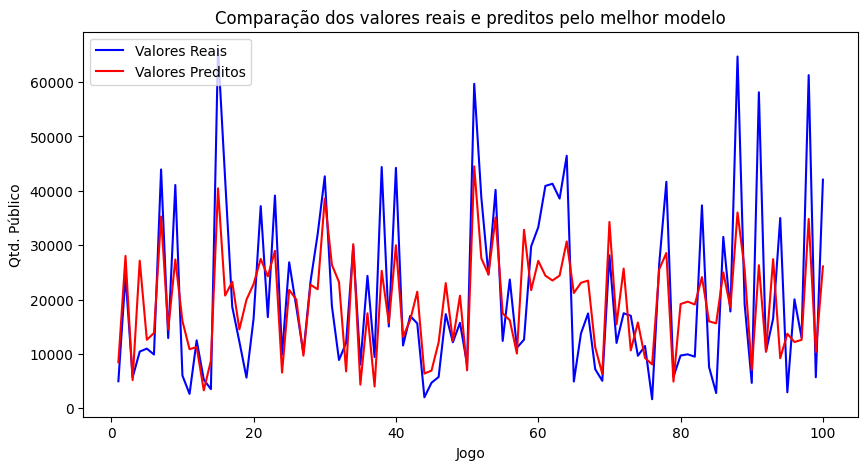

In [8]:
# TESTANDO O MELHOR MODELO COM DADOS SEPARADOS PARA TESTE
# Métricas de avaliação
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Pegando o melhor modelo
melhor_modelo = df_resultados.iloc[0]['Modelo']
print(melhor_modelo)

# Utilizando o modelo ajustado (treinado) para predizer os dados separados para teste
y_pred = melhor_modelo.predict(X_teste)

# Visualiza uma parte dos valores reais e dos respectivos valores preditos para comparação
print('Valores Preditos: ', list(y_pred[0:10].round(2)))
print('Valores Reais   : ', list(y_teste[0:10].round(2)))


# Calcula as Métricas de Avaliação com os dados separados para teste
mse = mean_squared_error(y_teste, y_pred)  # Erro quadrático médio (quanto menor, melhor)
rmse = np.sqrt(mse) # Raiz quadrada do mse (quanto menor, melhor)
mae = mean_absolute_error(y_teste, y_pred) # # Erro médio absoluto (quanto menor, melhor)
r2 = r2_score(y_teste, y_pred)  # R quadrado  (entre 0 e 1, quanto mais próximo de 1, melhor)

# Visualiza as métricas calculadas
print("MSE da Regressão Linear: {:.2f}".format(mse))
print("RMSE da Regressão Linear: {:.2f}".format(rmse))
print("MAE da Regressão Linear: {:.2f}".format(mae))
print("R2 da Regressão Linear: {:.2f}".format(r2))
print()
print()

# Plotar Gráfico preditos x reais (dispersão e linhas)
# Tamanho do Gráfico
plt.figure(figsize=(10,5))

#plt.scatter(y_teste, y_pred)
plt.plot( range(1, 101), y_teste[0:100], color = 'blue', label = 'Valores Reais') #, marker = '.' )
plt.plot(range(1, 101), y_pred[0:100], color = 'red', label = 'Valores Preditos') #, marker = '.' )

plt.title('Comparação dos valores reais e preditos pelo melhor modelo')
plt.xlabel('Jogo')
plt.ylabel('Qtd. Público')
plt.legend()
#plt.grid()


plt.show()

## Vamos também incluir um teste com combinação de modelos

In [16]:
# AGORA FAZ UM MODELO DE VOTING REGRESSOR COMBINANDO OS 4 MELHORES MODELOS DO RANKING ANTERIOR
# o VotingClassifier precisa dos modelos a serem combinados, como uma lista de tuplas (string do nome, modelo) como seu argumento
#https://www.geeksforgeeks.org/voting-regressor/
best_models = [( str(df_resultados.iloc[0]['Modelo'] ), df_resultados.iloc[0]['Modelo']),
               ( str(df_resultados.iloc[1]['Modelo'] ), df_resultados.iloc[1]['Modelo']),
               ( str(df_resultados.iloc[2]['Modelo'] ), df_resultados.iloc[2]['Modelo']),
               ( str(df_resultados.iloc[3]['Modelo'] ), df_resultados.iloc[3]['Modelo'])]

# Modelo
modelo_voting = VotingRegressor(best_models)
param = {'weights': [None] }

#validacao = RepeatedKFold(n_splits = 10, n_repeats = 3)
#validacao = RepeatedKFold(n_splits = 10, n_repeats = 1) # APENAS PARA SER MAIS RÁPIDO OS TESTES. MAS O CORRETO É O DE CIMA

#Métricas
#metricas = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error','r2']


############ COM GRIDSEARCH #########################
melhor = Tunagem(modelo_voting, X_treino, y_treino, param, tipo = 'grid')
result_melhor = { 'VotingRegressor()' : [melhor[0], melhor[1], melhor[2], melhor[3], melhor[4], melhor[5], melhor[6] ] }

# Coloca os resultados dos modelos rankeados, em um DF, para observarmos
df_result_voting = pd.DataFrame(result_melhor, index = ['Modelo', 'Melhores Parâmetros', 'Scorer', 'MSE', 'RMSE', 'MAE', 'R2']).T
#df_result_voting = df_result_voting.sort_values(by = 'Scorer') # Apresentado o DF de resultados, ordenado pelo MAE, para rankear os modelos

df_resultados = pd.concat([df_resultados, df_result_voting ]).sort_values(by = 'Scorer')

print()
print()
print('############# Modelos rankeados pelo Scorer (métrica MSE) #############')
display(df_resultados[['Melhores Parâmetros', 'Scorer', 'MSE', 'RMSE', 'MAE', 'R2']])
print()
print()

# Utilizando o modelo ajustado (treinado) para predizer os dados separados para teste
voting_ajustado = df_result_voting.iloc[0]['Modelo']
y_pred = voting_ajustado.predict(X_teste)

# Visualiza uma parte dos valores reais e dos respectivos valores preditos para comparação
print('Valores Preditos: ', list(y_pred[0:10].round(2)))
print('Valores Reais   : ', list(y_teste[0:10].round(2)))


############### FIM GRIDSEARCH ######################

'''
### SEM CROSS VALIDATION #######
# Fit the Voting Regressor on the training data
modelo_voting.fit(X_treino, y_treino)

# Make predictions on the testing data
pred = modelo_voting.predict(X_teste)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_teste, pred)

# Calculate R-squared (R2) score
r2 = r2_score(y_teste, pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'R-squared (R2) Score: {r2:.2f}')
################### FIM SEM CROSS VALIDATION ###########
'''


#############################################################################################

Fitting 10 folds for each of 1 candidates, totalling 10 fits


############# Modelos rankeados pelo Scorer (métrica MSE) #############


,Melhores Parâmetros,Scorer,MSE,RMSE,MAE,R2
VotingRegressor(),{'weights': None},90346363.2744,90346363.2744,9493.0407,6806.5747,0.4677
LinearRegression(),{'fit_intercept': True},95491302.3168,95491302.3168,9758.8305,7146.7398,0.4379
RandomForrestRegressor(),{'bootstrap': True},96240074.9303,96240074.9303,9797.5302,6986.8526,0.4355
GradientBoostingRegressor(),"{'max_depth': 3, 'max_leaf_nodes': None}",96494569.5215,96494569.5215,9810.3383,7263.1381,0.4340
ExtraTreesRegressor(),{'bootstrap': False},101479623.0633,101479623.0633,10068.3458,6977.1700,0.4014
BaggingRegressor(),{'estimator': None},102498895.2465,102498895.2465,10102.3997,7241.9397,0.3960
KNeighborsRegressor(),{'n_neighbors': 5},125842453.7659,125842453.7659,11205.7342,8175.8547,0.2535
SVR(),{'kernel': 'rbf'},183166935.5073,183166935.5073,13511.9637,9702.2242,0.0738
DecisionTreeRegressor(),{'max_depth': None},188667174.5643,188667174.5643,13723.8731,9574.0830,0.1142
GaussianNB(),{'priors': None},210425588.3076,210425588.3076,14482.4647,10315.0533,0.2360




Valores Preditos:  [8485.86, 25476.28, 7570.1, 20576.6, 13004.58, 14548.07, 29752.84, 13075.49, 35766.03, 24422.81]
Valores Reais   :  [4981.0, 24491.0, 5685.0, 10438.0, 10981.0, 9900.0, 43930.0, 12923.0, 41075.0, 6025.0]


"\n### SEM CROSS VALIDATION #######\n# Fit the Voting Regressor on the training data\nmodelo_voting.fit(X_treino, y_treino)\n\n# Make predictions on the testing data\npred = modelo_voting.predict(X_teste)\n\n# Calculate Mean Absolute Error (MAE)\nmae = mean_absolute_error(y_teste, pred)\n\n# Calculate R-squared (R2) score\nr2 = r2_score(y_teste, pred)\n\n# Print the evaluation metrics\nprint(f'Mean Absolute Error (MAE): {mae:.2f}')\nprint(f'R-squared (R2) Score: {r2:.2f}')\n################### FIM SEM CROSS VALIDATION ###########\n"

## ACRESCENTANDO MODELOS DE REDES NEURAIS PARA COMPARAÇÃO E SELEÇÃO FINAL DO MELHOR MODELO

## ALGUNS TESTES COM O MODELO SELECIONADO E SALVAMENTO DO MESMO PARA COLOCAR EM PRODUÇÃO
- Ver python impressionador
- Ver correlação com variável publico
- Ver importância de variáveis
